In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


### Import Modules

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from tqdm import tqdm
from models.BayesianLinRegressor import BayesLinRegressor
from rec.utils import kl_estimate_with_mc, plot_running_sum_1d, plot_running_sum_2d, \
plot_2d_distribution, plot_1d_distribution, compute_variational_posterior
from rec.Coders.Encoder_Parallel import Encoder as Empirical_Encoder
from rec.Coders.Encoder_Gaussian_Target import Encoder as Variational_Encoder
from rec.distributions.EmpiricalMixturePosterior_Parallel import EmpiricalMixturePosterior
from rec.distributions.VariationalPosterior import VariationalPosterior
from rec.samplers.GreedySampling import GreedySampler
from rec.samplers.ImportanceSampling import ImportanceSampler
from rec.distributions.CodingSampler import CodingSampler as coding_sampler

In [5]:
def create_lin_reg_problem(dim=2, alpha=0.01, signal_std=5, num_points=10, seed=0):
    """
    Creates a linear regression problem by sampling from a Bayesian Linear Regression Prior.
    After observing points, computes Bayesian Posterior.
    Returns target distribution.
    """
    
    # get Bayesian Linear Regression Object
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                            prior_alpha=alpha,
                            signal_std=signal_std,
                            num_targets=num_points,
                            seed=seed)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    
    return target

In [6]:
def encode_sample(target, posterior_method='empirical_distribution', omega=8, epsilon=0.,
                  n_samples=10, sampling_method='Greedy', seed=0, sigmas=None):
    
    if posterior_method == 'empirical_distribution':
        if sampling_method == 'Greedy':
            selection_sampler = GreedySampler
        else:
            selection_sampler = ImportanceSampler

        encoder = Empirical_Encoder(target,
                                    seed,
                                    coding_sampler,
                                    selection_sampler,
                                    EmpiricalMixturePosterior,
                                    omega,
                                    n_samples,
                                    epsilon=epsilon,
                                    )
    else:
        if sampling_method == 'Greedy':
            selection_sampler = GreedySampler
        else:
            selection_sampler = ImportanceSampler
        dim = target.mean.shape[0]
        if dim > 1:
            target = compute_variational_posterior(target)
        encoder = Variational_Encoder(target,
                                      seed,
                                      coding_sampler,
                                      selection_sampler,
                                      VariationalPosterior,
                                      omega,
                                      epsilon=epsilon,
                                      )
    if sigmas is not None:
        encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = sigmas
    return encoder, *encoder.run_encoder()

In [7]:
def run_and_plot_coded_sample(target=None, dim=2, alpha=0.01, signal_std=5, num_points=10, num_samples=10,
                              posterior_method='empirical_distribution', omega=8, epsilon=0.,
                              sampling_method='Greedy', seed=0, sigmas=None):

    # create problem
    if target is None:
        target = create_lin_reg_problem(dim=dim, alpha=alpha, signal_std=signal_std, num_points=num_points, seed=seed)
    encoder, z, indices = encode_sample(target, posterior_method=posterior_method, omega=omega, epsilon=epsilon,
                                        n_samples=num_samples, sampling_method=sampling_method, seed=seed,
                                        sigmas=sigmas)
    
    
    # plot things for 1 and 2 dimensions
    if dim == 2:
        plt.figure(figsize=(10,10))
        plot_2d_distribution(target)
        plot_running_sum_2d(encoder.selected_samples, plot_index_labels=False)
#         plt.plot(encoder.auxiliary_posterior.empirical_samples[:, 0], encoder.auxiliary_posterior.empirical_samples[:, 1],
#              'x')
        plt.plot(z[0], z[1], 'o')
    elif dim == 1:
        plot_1d_distribution(target)
        plot_running_sum_1d(target, encoder.selected_samples, plot_index_labels=False)
        plt.plot(z, torch.exp(target.log_prob(z)), 'o')
    
    print(target.log_prob(z))
    
    return z, encoder

# Easy 1d example

## Empirical Method

32.74700164794922


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(-1.3786)


(tensor([7.7098]), <rec.Coders.Encoder_Parallel.Encoder at 0x7fc92e47f7f0>)

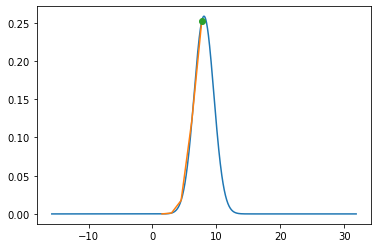

In [8]:
run_and_plot_coded_sample(dim=1, alpha=0.02, omega=8, num_samples=5)

## Variational Posterior Method

### In this case the Variational Posterior is identical to true posterior

32.74700164794922


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(-1.3527)


(tensor([8.0608]),
 <rec.Coders.Encoder_Gaussian_Target.Encoder at 0x7fc921481310>)

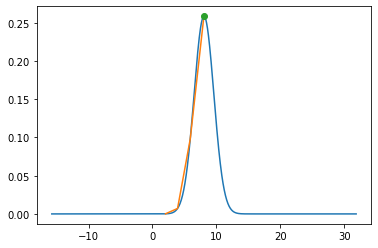

In [13]:
run_and_plot_coded_sample(dim=1, alpha=0.02, omega=8, posterior_method='Variational', epsilon=0.5)

# Hard 1d Example

## Empirical Method

112.81814575195312


  0%|          | 0/15 [00:00<?, ?it/s]

tensor(-5.0671)


tensor([13.4442])

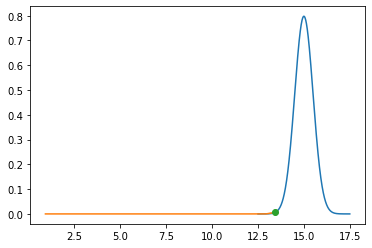

In [21]:
target = dist.multivariate_normal.MultivariateNormal(loc=torch.tensor([15.]), covariance_matrix=0.25*torch.eye(1))
sigmas = torch.tensor([0.0750, 0.0722, 0.0712, 0.0709, 0.0710, 0.0712, 0.0715, 0.0713, 0.0714,
        0.0718, 0.0717, 0.0700, 0.0647, 0.0556, 0.0204])
# sigmas=None
z, encoder = run_and_plot_coded_sample(target, dim=1, alpha=0.001, omega=8, num_samples=1, epsilon=0., sigmas=sigmas)
# plt.plot(encoder.auxiliary_posterior.empirical_samples, torch.exp(target.log_prob(encoder.auxiliary_posterior.empirical_samples)), 'x')
z

## Variational Posterior Method

### In this case the Variational Posterior is identical to true posterior

1066.7122802734375


  0%|          | 0/134 [00:00<?, ?it/s]

tensor(-6.5197)


(tensor([41.1176]),
 <rec.Coders.Encoder_Gaussian_Target.Encoder at 0x7fcecc382670>)

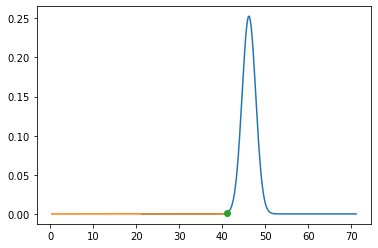

In [37]:
run_and_plot_coded_sample(dim=1, alpha=0.001, omega=8, posterior_method='Variational', epsilon=0.)

# Easy 2d Example

## Empirical Method

26.990970611572266


  0%|          | 0/4 [00:00<?, ?it/s]

tensor(-1.8783)


(tensor([ 1.6878, -6.7025]),
 <rec.Coders.Encoder_Parallel.Encoder at 0x7fc5e5a98970>)

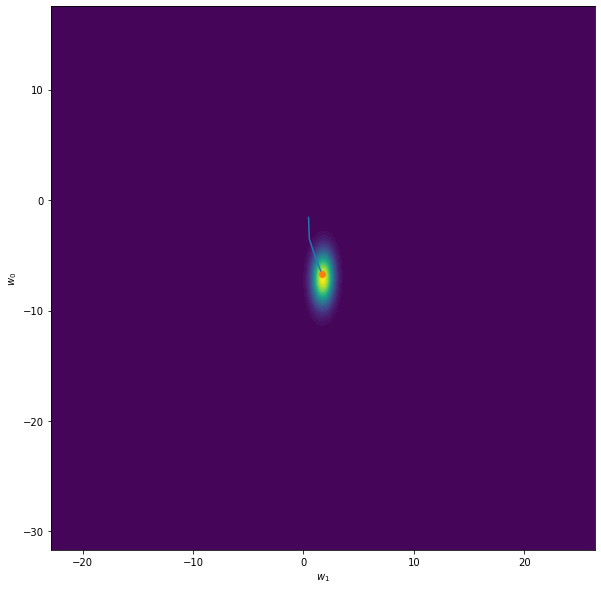

In [72]:
run_and_plot_coded_sample(dim=2, alpha=0.007, omega=8, num_samples=500)

## Variational Posterior Method

26.98949432373047


  0%|          | 0/4 [00:00<?, ?it/s]

tensor(-1.8429)


(tensor([ 1.7938, -7.0479]),
 <rec.Coders.Encoder_Gaussian_Target.Encoder at 0x7fc5e607d8b0>)

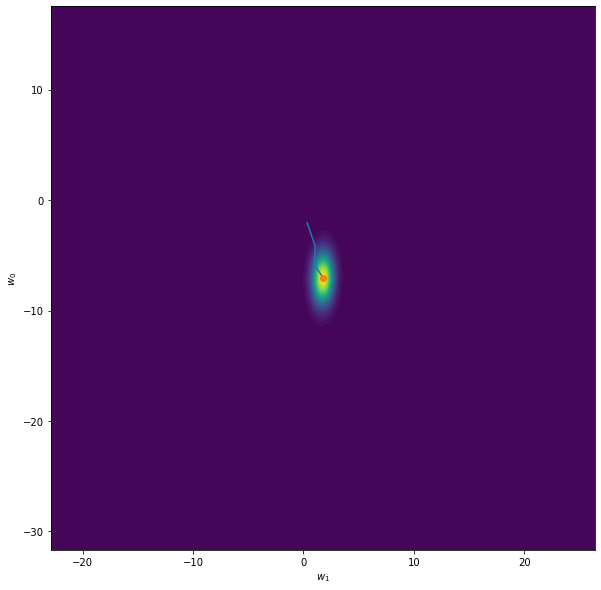

In [71]:
run_and_plot_coded_sample(dim=2, alpha=0.007, omega=8, posterior_method='Variational')

# Hard 1d Example

## Empirical Method

21152.318359375


  0%|          | 0/2645 [00:00<?, ?it/s]

tensor(-2.6913)


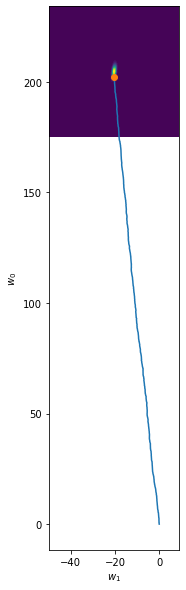

In [137]:
z, encoder = run_and_plot_coded_sample(dim=2, alpha=0.0001, omega=8, num_samples=10, epsilon=0.2, seed=169)

In [74]:
z.T @ z

tensor(32984.3555)

In [75]:
encoder.target.mean.T @ encoder.target.mean.T

tensor(42303.0664)

## Variational Posterior Method

1961.4158935546875


  0%|          | 0/246 [00:00<?, ?it/s]

tensor(-12.8404)


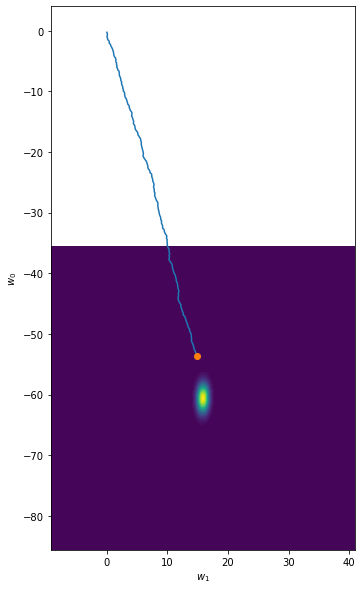

In [69]:
z, encoder = run_and_plot_coded_sample(dim=2, alpha=0.0001, omega=8, posterior_method='Variational', epsilon=0.)

In [66]:
z.T @ z

tensor(4871.0288)